In [23]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    # refrence: https://github.com/kohyar/LTTng_LSTM_Anomaly_Detection
    def forward(self, x, sequence_length, input_size):
        assert x.shape == (x.shape[0], sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)

        lstm_out, _ = self.lstm(x, (h0, c0))

        out = self.fc(lstm_out[:, -1, :])

        return out


def train_model(model, train_loader, epochs, optimizer, loss_function, sequence_length, input_size,val_loader):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            model.zero_grad()
            output = model(x, sequence_length, input_size)
            loss = loss_function(output, y)
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            # if i % (train_loader.batch_size*10) == 0:
                # print(
                #     f'Epoch {epoch} Batch {i//train_loader.batch_size} loss: {loss.item()}')
        print(f'Epoch {epoch} loss: {np.mean(epoch_losses)}, val_loss: {validate(model, val_loader)}')
        losses.append(epoch_losses)
    return losses

def validate(network, val_loader):
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch
            network.eval()
            o = network(features, features.shape[1], features.shape[2])
            loss = torch.nn.functional.mse_loss(o, labels)
            losses.append(loss.item())
    losses = np.array(losses)
    losses = losses[~np.isnan(losses)]
    return np.mean(losses)


In [24]:
# Data processing

import pandas as pd
from torch import tensor
from torch.utils.data import Dataset


df = pd.read_csv('consumption_and_temperatures.csv')
df["timestamp"] = pd.to_datetime(df["timestamp"])
print(f"Data is from {df['timestamp'].min()} to {df['timestamp'].max()}")

# Merge bidding areas and consumption data
df = pd.concat(
    [
        df[
            ["timestamp", bidding_area + "_consumption", bidding_area + "_temperature"]
        ].rename(
            columns={
                bidding_area + "_consumption": "consumption",
                bidding_area + "_temperature": "temperature",
                "timestamp": "timestamp",
            }
        ).merge(
            pd.DataFrame(
                {"bidding_area": [bidding_area] * len(df), "timestamp": df["timestamp"]}
            ),
            on="timestamp",
        )
        for bidding_area in ["NO1", "NO2", "NO3", "NO4", "NO5"]
    ]
)

# Remove nan values

df.sort_values(by=["timestamp", "bidding_area"], inplace=True)
df["hour"] = df["timestamp"].dt.hour
df["week"] = df["timestamp"].dt.week
df["previous_hour_consumption"] = df.groupby("bidding_area")["consumption"].shift(1)
df = df.dropna()

# OBS IKKE FRA SONDRE
df.drop("timestamp", axis=1, inplace=True)


# Normalize data
normalization_factors = {}
for col in [column for column in df.columns if column not in ["timestamp", "bidding_area"]]:
    normalization_factors[col] = {"mean": df[col].mean(), "std": df[col].std()}
    df[col] = (df[col] - normalization_factors[col]["mean"]) / normalization_factors[col][
        "std"
    ]

# One hot encode categorical features
for column in df.columns:
    if df[column].dtype == "object":
        df = pd.concat(
            [df, pd.get_dummies(df[column], prefix=column)],
            axis=1,
        )
        df.drop(column, axis=1, inplace=True)

class DataFrameDataset(Dataset):
    def __init__(self, dataframe, feature_columns, label_column, sequence_length):
        self.data = dataframe[feature_columns].values.astype(float)
        self.num_features = len(feature_columns)
        # convert data to sequences
        self.data = [
            self.data[i: i + sequence_length] for i in range(len(self.data) - sequence_length)
        ]
        self.labels = dataframe[label_column].values.astype(float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return tensor(self.data[idx]).float(), tensor(self.labels[idx]).float()

Data is from 2017-05-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00


C:\Users\Jonah\AppData\Local\Temp\ipykernel_2864\1571946022.py:37: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df["timestamp"].dt.week


In [25]:
from load_data import getTrainingSet, getValidationSet
dataset = getTrainingSet()
val_set = getValidationSet()
input_size = len(dataset.X[0][0])
sequence_length = len(dataset.X[0])
        # sequence_length = 24
        # dataset = DataFrameDataset(df, [column for column in df.columns if column != "consumption"], "consumption", sequence_length)
        # input_size = dataset.num_features
hidden_size = 100
num_layers = 1
output_size = 1
learning_rate = 0.001
batch_size = 32
epochs = 10

print(f'input_size: {input_size}, sequence_length: {sequence_length}')

model = LSTM(input_size, hidden_size, num_layers, output_size)
loss_function = nn.MSELoss()
adam = optim.Adam(model.parameters(), learning_rate)
train_dataloader = DataLoader(dataset, batch_size, shuffle=True)

losses = train_model(
    model,
    train_dataloader,
    epochs,
    adam,
    loss_function,
    sequence_length,
    input_size,
    val_loader=DataLoader(val_set, batch_size, shuffle=True)
)

# train(model, dataset, batch_size, epochs)

input_size: 6, sequence_length: 24
Epoch 0 loss: 1.001044841795942, val_loss: 1.0004650696499706
Epoch 1 loss: 1.00061440647301, val_loss: 1.0010881915484389
Epoch 2 loss: 0.9995704896911217, val_loss: 1.0015729265670255
Epoch 3 loss: 1.0000651679171697, val_loss: 1.0014638891775314
Epoch 4 loss: 0.9998110707060699, val_loss: 1.001749071601319
Epoch 5 loss: 0.9995066165434618, val_loss: 1.0006837733804363
Epoch 6 loss: 0.25070436894392295, val_loss: 2.042711755020978
Epoch 7 loss: 0.012964764551937675, val_loss: 1.9658114795815456
Epoch 8 loss: 0.011915636626386634, val_loss: 1.9572195979013836
Epoch 9 loss: 0.011207665092852238, val_loss: 2.0254006823448285


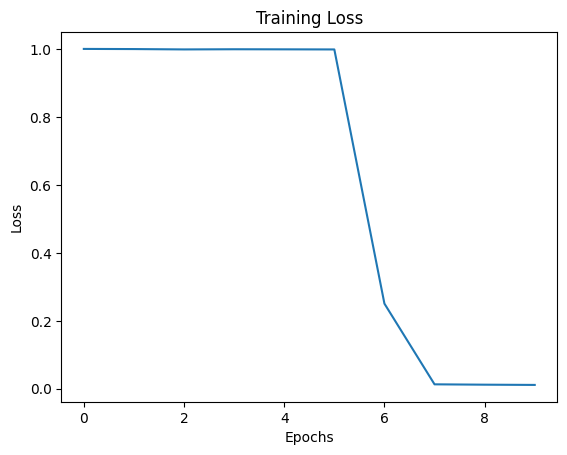

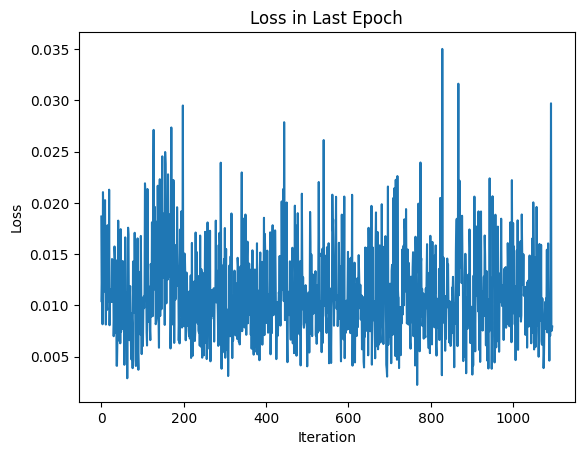

In [26]:
import matplotlib.pyplot as plt

plt.plot([sum(epoch_losses)/len(epoch_losses) for epoch_losses in losses])
# new_epochs = range(0, len(losses), len(losses)//epochs)
# for epoch in new_epochs:
#     plt.axvline(x=epoch, color='r', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(losses[-1])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss in Last Epoch')
plt.show()
